In [12]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
original_dim = 50
encoding_dim = 128  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(original_dim**2,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(original_dim**2, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


In [14]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [15]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [16]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
# from keras.datasets import mnist
import numpy as np
# (x_train, _), (x_test, _) = mnist.load_data()

In [8]:
from time import time

def load_data():
    start = time()
    print('Getting labels')
    labels = np.loadtxt('data/labels.csv', delimiter=',', dtype=np.float32)
    labels = np.minimum(1.0, labels)
    labels.shape = (-1,1)

    print('Getting features')
    rgb = np.loadtxt('data/rgbdata50.csv', delimiter=',', dtype=np.float32)
#     rgb = np.loadtxt('data/4096features.csv', delimiter=',', dtype=np.float32)
#     rgb.shape = (-1, 64, 64)
    rgb.shape = (-1, 3, 50, 50)
    rgb = np.mean(rgb, axis=1)
    print('Job completed in: {} seconds'.format(time()-start))
    return rgb, labels

rgb, labels = load_data()
nb_classes = 1
print('rgb shape', rgb.shape)
print('labels shape', labels.shape)

Getting labels
Getting features
Job completed in: 87.50538396835327 seconds
rgb shape (12380, 50, 50)
labels shape (12380, 1)


In [9]:
def divide_data(rgb, labels, data_size=None, train_ratio=0.9):
    '''Randomly select given number of data and divide into training set and test set'''
    data_size_max = labels.shape[0]
    data_size = data_size_max if data_size is None else data_size
    train_size = int(np.floor(train_ratio * data_size))

    mask = list(range(data_size_max))
    mask = np.random.choice(mask, data_size, replace=False)
    rgb = rgb[mask]/255
    labels = np.minimum(labels[mask], 1.0)
    x_train = rgb[:train_size]
    y_train = labels[:train_size]
    x_test = rgb[train_size:]
    y_test = labels[train_size:]

    return (x_train, y_train), (x_test, y_test)

# CHOICE 2: SINGLE CLASS
nb_classes = 1
label_md = np.copy(labels)
label_md.shape = (-1,nb_classes)

(x_train, y_train), (x_test, y_test) = divide_data(rgb, label_md, 
#                                                    data_size=1000, 
                                                   train_ratio=10/11) # 10/11 this ratio allows train = 10*test
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)


x_train shape: (11254, 50, 50)
y_train shape: (11254, 1)


In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(11254, 2500)
(1126, 2500)


In [ ]:
x_train.shape = (-1, original_dim**2)
print(x_train.shape)

In [17]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
               callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 11254 samples, validate on 1126 samples
Epoch 1/100
11254/11254 [==============================] - 2s - loss: 0.6889 - val_loss: 0.6845
Epoch 2/100
11254/11254 [==============================] - 2s - loss: 0.6798 - val_loss: 0.6747
Epoch 3/100
11254/11254 [==============================] - 2s - loss: 0.6681 - val_loss: 0.6597
Epoch 4/100
11254/11254 [==============================] - 2s - loss: 0.6450 - val_loss: 0.6236
Epoch 5/100
11254/11254 [==============================] - 2s - loss: 0.5811 - val_loss: 0.5210
Epoch 6/100
11254/11254 [==============================] - 2s - loss: 0.4296 - val_loss: 0.3270
Epoch 7/100
11254/11254 [==============================] - 2s - loss: 0.2390 - val_loss: 0.1651
Epoch 8/100
11254/11254 [==============================] - 2s - loss: 0.1227 - val_loss: 0.0901
Epoch 9/100
11254/11254 [==============================] - 2s - loss: 0.0721 - val_loss: 0.0579
Epoch 10/100
11254/11254 [==============================] - 2s - loss: 0.0492 - val_los

In [18]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

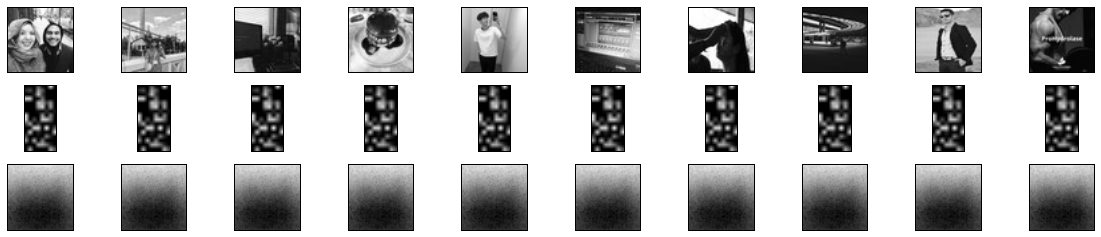

In [19]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline 
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(original_dim, original_dim))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(decoded_imgs[i].reshape(original_dim, original_dim))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

ValueError: Error when checking target: expected conv2d_63 to have shape (None, 1, 28, 4) but got array with shape (60000, 28, 28, 1)

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
print(keras.__version__)

2.0.4


function to load data (RGB)

file structure:

```sh
NeuralNetwork_RGB.ipynb
./data:
    labels.csv
    posts_filtered.csv
    rgbdata50.csv
```


In [2]:
def load_data():
    start = time()
    labels = np.loadtxt('data/labels.csv', delimiter=',', dtype=np.float32)
    labels = np.minimum(1.0, labels)
    data_size = labels.shape[0]
    # lables.shape: (1,data_size)
    labels.shape = (-1,1)

    f4096 = np.loadtxt('data/4096features.csv', delimiter=',', dtype=np.float32)
    f4096.shape = (-1, 4096)
    print('Job completed in: {} seconds'.format(time()-start))
    return f4096, labels

f4096, labels = load_data()
print('f4096 shape', f4096.shape)
print('labels shape', labels.shape)

Job completed in: 45.96432590484619 seconds
f4096 shape (12380, 4096)
labels shape (12380, 1)


In [7]:
def divide_data(f4096, labels, data_size=None, train_ratio=0.9):
    '''Randomly select given number of data and divide into training set and test set'''
    data_size_max = labels.shape[0]
    data_size = data_size_max if data_size is None else data_size
    train_size = int(np.floor(train_ratio * data_size))

    mask = list(range(data_size_max))
    mask = np.random.choice(mask, data_size, replace=False)
    f4096 = f4096[mask]/255
    labels = np.minimum(labels[mask], 1.0)
    X_train = f4096[:train_size]
    y_train = labels[:train_size]
    X_test = f4096[train_size:]
    y_test = labels[train_size:]

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = divide_data(f4096, labels, 
#                                                    data_size=1000, 
                                                   train_ratio=10/11) # 10/11 this ratio allows train = 10*test
print('X_train shape:', X_train.shape)

print('X_train', X_train[:2])
print('y_train', y_train[:2])

X_train shape: (11254, 4096)
X_train [[ 0.          0.          0.         ...,  0.          0.          0.00035396]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
y_train [[ 0.15116279]
 [ 0.32911393]]


In [8]:
def buildModel(shape):
    model = Sequential()
    print(shape)
    model.add(Conv2D(32, (3, 3),
                     padding='same',
                     activation='relu',
                     data_format="channels_first",
                     input_shape=shape))
    model.add(Conv2D(32, (3, 3),
                     data_format="channels_first",
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (4, 4),
                     data_format="channels_first",
                     activation='relu'))
    model.add(Conv2D(32, (3, 3),
                     data_format="channels_first",
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, 
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='relu'))
    
    rmsprop = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
    def abs_diff(y_true, y_pred):
        return np.absolute(y_true - y_pred)
    model.compile(optimizer=rmsprop,
                  loss='mse',
                  metrics=[abs_diff, 'mse'])

    return model

input_shape = X_train.shape[1:]
model = buildModel(input_shape)
print(model)


(4096,)


ValueError: Input 0 is incompatible with layer conv2d_1: expected ndim=4, found ndim=2

In [59]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11254, 3, 50, 50) (1126, 3, 50, 50) (11254, 1) (1126, 1)


In [76]:
hist = model.fit(X_train, y_train,
                batch_size=32, 
                epochs=2,
                verbose=1,
                validation_data=(X_test, y_test))
          
score = model.evaluate(X_test, y_test)


print('Validation loss:', round(score[0],2))
print('Validation accuracy:', round(100*score[1],2), "%")

Train on 11254 samples, validate on 1126 samples
Epoch 1/2
11254/11254 [==============================] - 132s - loss: 0.0230 - abs_diff: 0.1047 - mean_squared_error: 0.0230 - val_loss: 0.0132 - val_abs_diff: 0.0853 - val_mean_squared_error: 0.0132
Epoch 2/2
1120/1126 [============================>.] - ETA: 0sValidation loss: 0.01
Validation accuracy: 8.69 %


In [29]:
print(keras.__version__)
x = np.array([1,23,4,5,6,6,423,2])
print(np.minimum(1, 4.5))
print(model.metrics_names)

2.0.4
1.0
['loss', 'acc']


### Plot Predicted values vs Real values

There are almost no correlation between RGB and lables

In [83]:
y_prediction = model.predict(X_test, verbose=1)
#y_test = y_test

1120/1126 [============================>.] - ETA: 0s

(1126,)
[ 0.15261959  0.06530612  0.12610489  0.01714286  0.17374136  0.18250951
  0.02650212  0.25170067  0.2857143   0.16187051]


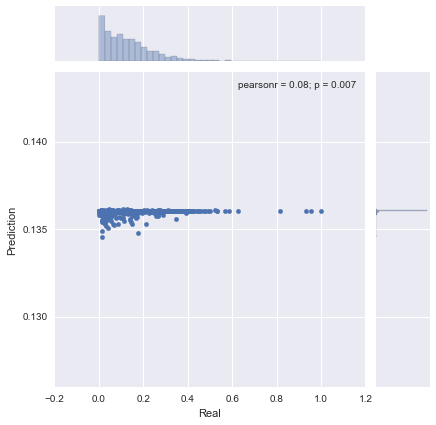

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

y_test.shape = (-1)
y_prediction.shape = (-1)
print(y_test.shape)
print(y_test[0:10])
data = np.array([y_prediction, y_test]).T
# data.shape = (2, -1)
# plt.title('CNN on RGB of Dataset#1')
df = pd.DataFrame(data, columns=["Prediction", "Real"])
sns.jointplot(x="Real", y="Prediction", data=df);

In [112]:
#Input an image, resize as 50x50, output RGB data
# from PIL import Image
# img = Image.open('images/12403.jpg')
# img_size = 50
# img.show()

# img = img.resize((img_size,img_size),Image.ANTIALIAS)
# pixels = np.array(img.getdata(), dtype=int)/255
# model.predict(pixels, batch_size=32, verbose=1)

In [92]:
lab = [1,3,543,6,3,547,45]
print(np.minimum(1.0, lab))

[ 1.  1.  1.  1.  1.  1.  1.]
